## Kaggle Data Science Survey

### Import libraries

In [4]:
import pandas as pd
import urllib.request
import zipfile

### Download and extract data

In [5]:
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip' # URL to download the data

In [6]:
fname = 'kaggle-survery-2018.zip' # save file as this name
member_name = 'multipleChoiceResponses.csv' # name of the csv file

In [8]:
# Extract the csv file from the zip file
def extract_zip(src, dst, member_name): 
    """
    Extract a member file from a zip file and read it into a Pandas DataFrame.
    
    Parameters
    ----------    
    src (str): path to the zip file
    dst (str): path to the destination file
    member_name (str): name of the member file to be read into a DataFrame
    
    Returns
    ----------
    pandas.DataFrame: DataFrame containing the member file
    """
    url = src # URL to download the data
    fname = dst # save file as this name
    fin = urllib.request.urlopen(url) # open the url
    data = fin.read() # read the data

    with open(dst, mode='wb') as fout: # save the data to a file
        fout.write(data) # write the data to the file
    with zipfile.ZipFile(dst) as z: # open the zip file
        kag = pd.read_csv(z.open(member_name)) # read the csv file
        kag_questions = kag.iloc[0] # get the questions
        raw = kag.iloc[1:] # get the answers
        return raw # return the answers

In [9]:
raw = extract_zip(url, fname, member_name) # extract the data

/var/folders/02/t1w3xsh916z60p5jhmd5xbc00000gn/T/ipykernel_12554/4077219888.py:24: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  kag = pd.read_csv(z.open(member_name)) # read the csv file


### Build a cleanup pipeline

In [10]:
# Build a cleanup function that uses Sckit-Learn pipelines
def tweak_kag(df_: pd.DataFrame) -> pd.DataFrame:
    """
    Tweak the Kaggle survey data and return a new DataFrame.
    This function takes a Pandas DataFrame containing Kaggle
    survey data as input and returns a new DataFrame. The
    modifications include extracting and transforming certain
    columns, renaming columns, and selecting a subset of columns.
    
    Parameters
    ----------
    df_ : pd.DataFrame
        The input DataFrame containing Kaggle survey data.
    Returns
    -------
    pd.DataFrame
        The output DataFrame containing the transformed data.
    """

    return (df_
            .assign(age=df_.Q2.str.slice(0, 2).astype(int),
                    education=df_.Q4.replace({'Master’s degree': 18, 
                                              'Bachelor’s degree': 16,
                                              'Doctoral degree': 20,
            'Some college/university study without earning a bachelor’s degree': 13,
                                              'Professional degree': 19,
                                              'I prefer not to answer': None,
                                              'No formal education past high school': 12}), 
                    major=(df_.Q5
                                .pipe(topn, n=3)
                                .replace({
                                            'Computer science (software engineering, etc.)': 'cs',
                                            'Engineering (non-computer focused)': 'eng',
                                            'Mathematics or statistics': 'stat'})
                                ),
                                years_exp=(df_.Q8.str.replace('+','', regex=False)
                                    .str.split('-', expand=True) .iloc[:,0]
                                    .astype(float)),
                                compensation=(df_.Q9.str.replace('+','', regex=False) 
                                              .str.replace(',','', regex=False) .str.replace('500000', '500', regex=False)
                        .str.replace('I do not wish to disclose my approximate yearly compensation', '0', regex=False)
                                    .str.split('-', expand=True) .iloc[:,0]
                                    .fillna(0)
                                    .astype(int)
                                    .mul(1_000)
                                    ),
                                    python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
                                    r=df_.Q16_Part_2.fillna(0).replace('R', 1),
                                    sql=df_.Q16_Part_3.fillna(0).replace('SQL', 1)
                                )#assign
                            .rename(columns=lambda col:col.replace(' ', '_'))
                            .loc[:, 'Q1,Q3,age,education,major,years_exp,compensation,'
                                    'python,r,sql'.split(',')]
                        )              

In [11]:
def topn(ser, n=5, default='other'): 
    """
    Replace all values in a Pandas Series that are not among
    the top `n` most frequent values with a default value.
    This function takes a Pandas Series and returns a new
    Series with the values replaced as described above. The
    top `n` most frequent values are determined using the
    `value_counts` method of the input Series.
    
    Parameters
    ----------
    ser : pd.Series
        The input Series.
    n : int, optional
        The number of most frequent values to keep. The
        default value is 5.
    default : str, optional
        The default value to use for values that are not among
        the top `n` most frequent values. The default value is
        'other'.
    
    Returns
    -------
    pd.Series
        The modified Series with the values replaced.
    """ 
    counts = ser.value_counts() # get the value counts
    return ser.where(ser.isin(counts.index[:n]), default) # return the modified series

Create the TweakKagTransformer class to wrap tweak_kag and embed cleanup logic into the pipeline functionality of Scikit-Learn.

In [12]:
from feature_engine import encoding, imputation
from sklearn import base, pipeline

In [13]:
class TweakKagTransformer(base.BaseEstimator, base.TransformerMixin):
    """
        A transformer for tweaking Kaggle survey data.
        This transformer takes a Pandas DataFrame containing
        Kaggle survey data as input and returns a new version of
        the DataFrame. The modifications include extracting and
        transforming certain columns, renaming columns, and
        selecting a subset of columns.
    Parameters
    ----------
        ycol : str, optional
        The name of the column to be used as the target variable.
        If not specified, the target variable will not be set.
    Attributes
    ----------
        ycol : str
    """
    def __init__(self, ycol=None):
        self.ycol = ycol

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return tweak_kag(X)

Create a new function, get_rawX_y, which takes the original data and return an X DataFrame and a y Series ready to feed into the pipeline for further cleanup.

In [14]:
def get_rawX_y(df, y_col):
    raw = (df.query('Q3.isin(["United States of America", "China", "India"]) '
                    'and Q6.isin(["Data Scientist", "Software Engineer"])') 
    )
    return raw.drop(columns=[y_col]), raw[y_col]

Create the pipeline and prepare to run the code

In [15]:
# Create a pipeline to preprocess the data
kag_pl = pipeline.Pipeline(
    [('tweak', TweakKagTransformer()),
     ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True,
                                    variables=['Q1', 'Q3', 'major'])),
     ('num_impute', imputation.MeanMedianImputer(imputation_method='median',
                                               variables=['education', 'years_exp']))
    ]
)

#### Split the data

In [16]:
from sklearn import model_selection
kag_X, kag_y = get_rawX_y(raw, 'Q6')
kag_X_train, kag_X_test, kag_y_train, kag_y_test = model_selection.train_test_split(kag_X, kag_y, test_size=.3, stratify=kag_y, random_state=42)

#### Fit the model

In [17]:
X_train = kag_pl.fit_transform(kag_X_train, kag_y_train)
X_test = kag_pl.transform(kag_X_test)
print(X_train)

       age  education  years_exp  compensation  python  r  sql  Q1_Male  \
587     25       18.0        4.0             0       1  0    1        1   
3065    22       16.0        1.0         10000       1  0    0        1   
8435    22       18.0        1.0             0       1  0    0        1   
3110    40       20.0        3.0        125000       1  0    1        0   
16372   45       12.0        5.0        100000       1  0    1        1   
...    ...        ...        ...           ...     ... ..  ...      ...   
16608   25       16.0        2.0         10000       0  0    1        1   
7325    18       16.0        1.0         30000       1  0    1        1   
21810   18       16.0        2.0             0       0  0    0        1   
4917    25       18.0        1.0        100000       1  0    1        1   
639     25       18.0        1.0         10000       1  0    0        0   

       Q1_Female  Q1_Prefer not to say  Q1_Prefer to self-describe  \
587            0             

#### Check the labels

In [18]:
kag_y_train

587      Software Engineer
3065        Data Scientist
8435        Data Scientist
3110        Data Scientist
16372    Software Engineer
               ...        
16608    Software Engineer
7325     Software Engineer
21810       Data Scientist
4917        Data Scientist
639         Data Scientist
Name: Q6, Length: 2110, dtype: object

### EDA

#### Start with correlations

In [19]:
(X_train # use X_train to compute the correlation
 .assign(data_scientist=kag_y_train == 'Data Scientist') # add the target variable
 .corr(method='spearman') # compute the Spearman correlation
 .style # use the Styler to format the output
 .background_gradient(cmap='RdBu', vmax=1, vmin=-1) # use a diverging color map
 .set_sticky(axis='index') # make the first column sticky
 )

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat,data_scientist
age,1.000000,0.345717,0.644863,0.451349,0.046651,0.127667,0.134325,0.014277,-0.033693,0.051232,0.041474,0.371123,-0.363626,-0.023384,-0.223529,0.201910,0.006262,0.073864,0.075440
education,0.345717,1.000000,0.098849,0.241393,0.060259,0.151244,0.066620,-0.079534,0.064777,0.060984,0.002701,0.272790,-0.273408,-0.006441,-0.216724,0.164771,-0.001043,0.121294,0.266717
years_exp,0.644863,0.098849,1.000000,0.255164,-0.055408,0.012090,0.050181,0.083624,-0.097564,0.034470,0.016784,0.117912,-0.136666,0.029630,-0.046551,0.018267,0.004264,0.042917,-0.145461
compensation,0.451349,0.241393,0.255164,1.000000,0.165070,0.171485,0.201336,0.000967,0.002912,-0.035554,0.049881,0.616759,-0.556154,-0.123281,-0.225934,0.241580,-0.060256,0.109100,0.174434
python,0.046651,0.060259,-0.055408,0.165070,1.000000,0.183665,0.287957,0.039944,-0.039207,-0.006729,-0.000553,0.052339,-0.043101,-0.017642,-0.095136,0.093887,0.008640,0.013474,0.121741
r,0.127667,0.151244,0.012090,0.171485,0.183665,1.000000,0.276862,-0.066982,0.068157,0.004831,-0.004454,0.178682,-0.105625,-0.133029,-0.205538,0.139994,-0.022082,0.162942,0.329124
sql,0.134325,0.066620,0.050181,0.201336,0.287957,0.276862,1.000000,-0.026692,0.032639,-0.010814,-0.018499,0.166587,-0.107382,-0.108406,-0.130081,0.109862,-0.012964,0.073906,0.117941
Q1_Male,0.014277,-0.079534,0.083624,0.000967,0.039944,-0.066982,-0.026692,1.000000,-0.957007,-0.222963,-0.094664,-0.144665,0.116961,0.052566,0.062605,-0.071139,0.028492,-0.039544,-0.091126
Q1_Female,-0.033693,0.064777,-0.097564,0.002912,-0.039207,0.068157,0.032639,-0.957007,1.000000,-0.045225,-0.019201,0.131051,-0.105490,-0.048434,-0.049753,0.064054,-0.034760,0.036779,0.086614
Q1_Prefer not to say,0.051232,0.060984,0.034470,-0.035554,-0.006729,0.004831,-0.010814,-0.222963,-0.045225,1.000000,-0.004473,0.046366,-0.038587,-0.014918,-0.045908,0.010336,0.029149,0.021052,0.018540


#### Stacked bar plot

<AxesSubplot:xlabel='r'>

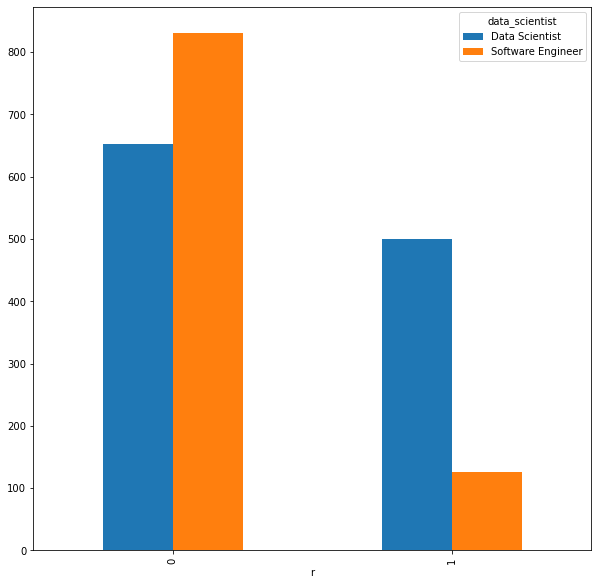

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10)) # create a figure and axes
(X_train # use the X_train dataframe
 .assign(data_scientist = kag_y_train) # add the target variable
 .groupby('r') # group by the R column
 .data_scientist # select the target variable
 .value_counts() # count the number of observations in each group
 .unstack() # unstack the target variable
 .plot.bar(ax=ax) # plot the bar chart
 )

#### Crosstab

<AxesSubplot:xlabel='major_cs'>

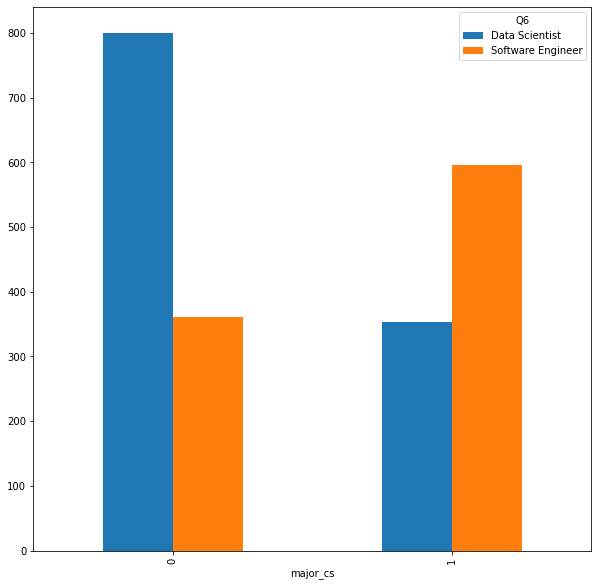

In [21]:
fig, ax = plt.subplots(figsize=(10, 10)) # create a figure and axes
(pd.crosstab(index=X_train['major_cs'], # use the X_train dataframe
             columns=kag_y) # add the target variable
             .plot.bar(ax=ax) # plot the bar chart
             )

#### Scatter plot

<AxesSubplot:xlabel='years_exp', ylabel='compensation'>

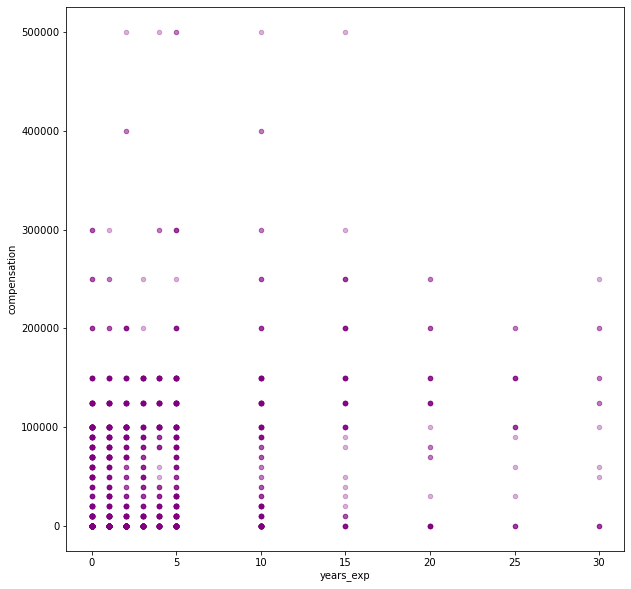

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
(X_train
    .plot.scatter(x='years_exp', y='compensation', alpha=.3, ax=ax, c='purple')
)

In [23]:
import seaborn

In [24]:
# What version of seaborn are you using?
print(seaborn.__version__)

0.12.2


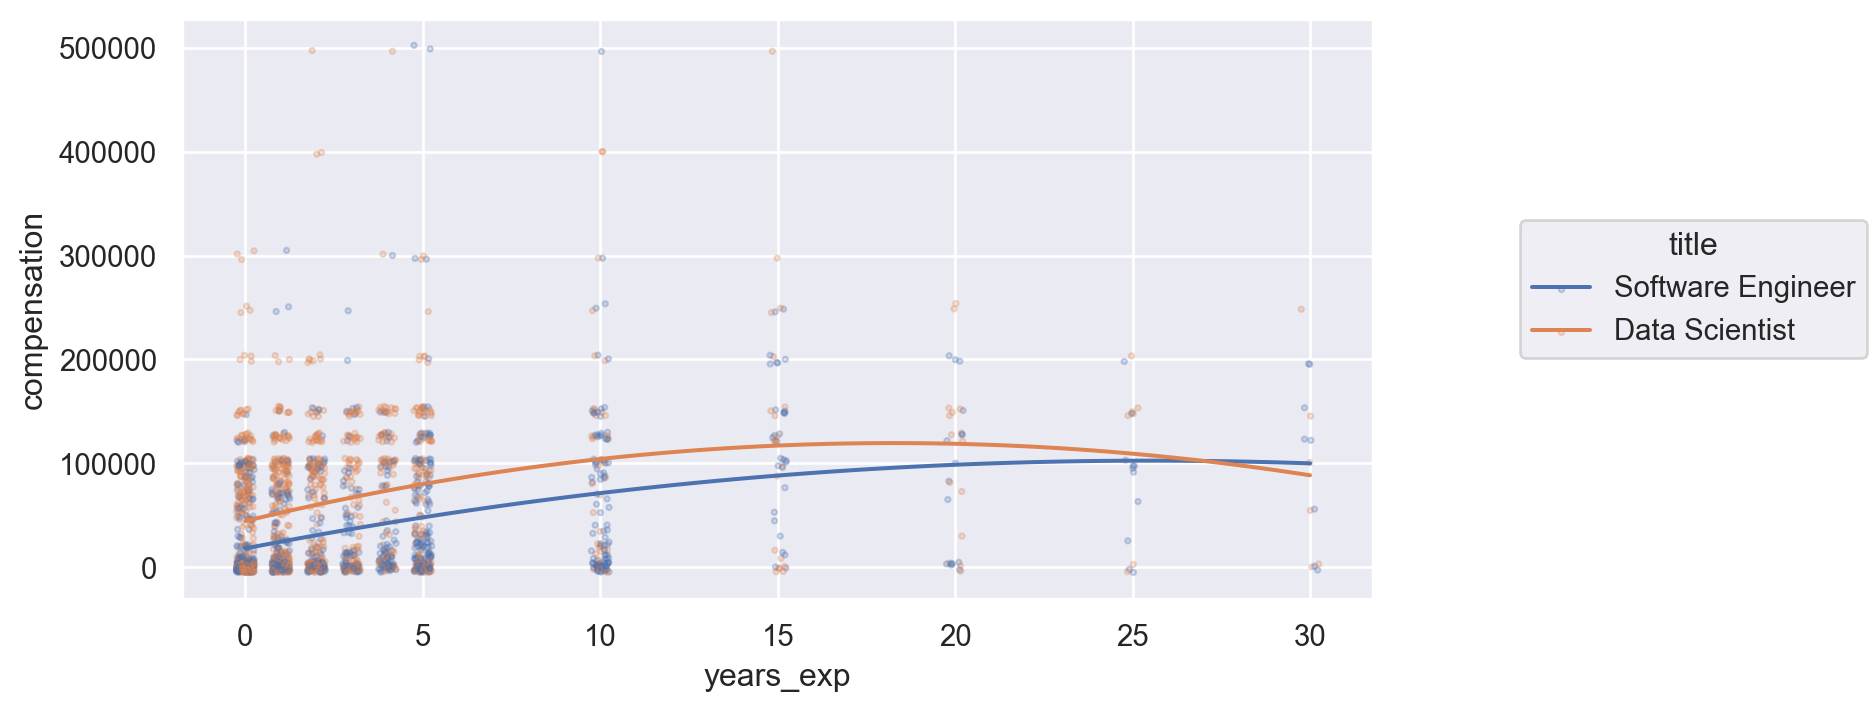

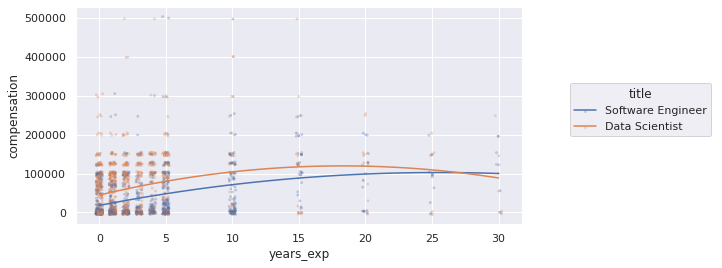

In [27]:
import seaborn.objects as so

fig = plt.figure(figsize=(8, 4)) 
(so
.Plot(X_train.assign(title=kag_y_train), x='years_exp', y='compensation', color='title') .add(so.Dots(alpha=.3, pointsize=2), so.Jitter(x=.5, y=10_000))
.add(so.Line(), so.PolyFit())
.on(fig) # not required unless saving to image
)